# Analysis of HU OOP results


In [1]:
# Imports
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath('')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker

from scipy.stats import pearsonr
import pingouin as pg

from lib.analysis_tools import plot_boxes_grade_cats

In [2]:
# Load ABT cleanup an concatenate
abt = pd.read_csv('data/hu_oop_abt.csv')
abt

,file,assignment,kloc,grade,errors_total,pmd_total,checkstyle_total,errors_count,pmd_count,checkstyle_count,...,checkstyle_NPathComplexity,checkstyle_NestedIfDepth,checkstyle_NestedTryDepth,checkstyle_ParameterAssignment,checkstyle_ReturnCount,checkstyle_SimplifyBooleanExpression,checkstyle_SimplifyBooleanReturn,checkstyle_UnusedLocalVariable,checkstyle_VariableDeclarationUsageDistance,checkstyle_VisibilityModifier
0,a250663,HU OOP,1.760,9.411765,538.636364,347.159091,191.477273,20.454545,12.500000,7.954545,...,0.000000,0.0,0.000000,0.000000,1.136364,0.0,0.000000,0.000000,0.568182,1.136364
1,a252724,HU OOP,0.786,2.352941,334.605598,284.987277,49.618321,31.806616,22.900763,8.905852,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.272265,0.000000
2,a244602,HU OOP,1.892,10.000000,477.272727,304.968288,172.304440,25.369979,15.856237,9.513742,...,0.528541,0.0,0.000000,0.000000,2.114165,0.0,0.000000,0.528541,0.528541,2.642706
3,a250728,HU OOP,1.511,9.411765,456.651224,347.452019,109.199206,29.119788,20.516214,8.603574,...,0.000000,0.0,0.000000,0.661813,1.323627,0.0,0.000000,1.323627,0.661813,1.323627
4,a252798,HU OOP,1.458,10.000000,650.205761,408.093278,242.112483,28.120713,17.832647,10.288066,...,0.000000,0.0,0.000000,0.000000,2.743484,0.0,0.685871,2.743484,0.685871,16.460905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,a81277,HU OOP,1.365,9.411765,528.937729,336.996337,191.941392,32.234432,22.710623,9.523810,...,0.000000,0.0,0.000000,0.732601,0.000000,0.0,0.000000,0.000000,5.128205,2.197802
154,a242532,HU OOP,1.739,10.000000,541.115584,328.924669,212.190914,23.576768,14.376078,9.200690,...,0.000000,0.0,0.000000,0.000000,2.875216,0.0,0.000000,0.000000,0.575043,10.350776
155,a92019,HU OOP,1.102,5.882353,467.332123,283.121597,184.210526,29.038113,19.056261,9.981851,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.907441,0.000000
156,a92317,HU OOP,1.477,0.000000,576.844956,377.115775,199.729181,29.790115,18.957346,10.832769,...,1.354096,0.0,0.677048,0.000000,2.708192,0.0,0.000000,0.000000,1.354096,2.031144


# Cleanup

In [3]:
print(f"Number of assignments total: {abt['grade'].count()} ")
print(f"Number of assignments with a grade of zero: {abt[abt['grade'] < 1]['grade'].count()}")
print(f"Number of assignments where no errors could be detected: {abt[abt['errors_total'] == 0]['grade'].count()}")


abt_clean = abt[(abt['grade'] >= 1) & (abt['errors_total'] > 0)].reset_index(drop = True).copy()

print(f"Number of assignments after cleanup: {abt_clean['grade'].count()}")

# Drop columns for subgrades
abt_clean = abt_clean.drop([x for x in abt_clean.columns if x.startswith('subgrade')],axis = 1)

# NaNs are metrics that were not found for a specific assignment. Just set them to 0
abt_clean = abt_clean.fillna(0)

# Failing grades are distributed unevenly because they contain knockout values.
# Set all of them to 4.0 if they're lower than 4.0
abt_clean.grade = abt_clean['grade'].map(lambda x : 5.0 if x < 5.0 else x)


Number of assignments total: 158 
Number of assignments with a grade of zero: 8
Number of assignments where no errors could be detected: 0
Number of assignments after cleanup: 150


In [4]:

# Only retain columns for categories, clusters and totals.
abt_final = abt_clean[['grade', 
                       'errors_count',
                       'errors_total'] + [x for x in abt_clean.columns if x.startswith('cluster_') ] +
                       ['pmd_count',
                       'pmd_total'] + [x for x in abt_clean.columns if x.startswith('pmd_cat_')] +
                       ['checkstyle_count',
                        'checkstyle_total'] + [x for x in abt_clean.columns if x.startswith('checkstyle_cat_')]].reset_index(drop = True).copy()

# Additionally, create columns for the categories teachers were
# questioned about.
abt_final['cat_Code style'] = abt_final['pmd_cat_Code style'].copy()
abt_final['cat_Design'] = abt_final['pmd_cat_Design'] + abt_final['checkstyle_cat_Class Design']
abt_final['cat_ErrorProne'] = abt_final['pmd_cat_ErrorProne'].copy()
abt_final['cat_SizeViolations'] = abt_final['checkstyle_cat_SizeViolations'].copy()



In [5]:
# When graphing box plots, normalize values between 0 and 1
must_normalize = False

if must_normalize:
    for x in abt_final.columns:
        if x == 'grade':
          continue
        abt_final[x] = abt_final[x] / abt_final[x].max()
abt_final
    # .apply(lambda x : x / x.max(), axis = 0)

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,...,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
0,9.411765,20.454545,538.636364,290.909091,1.136364,62.500000,184.090909,0.000000,12.500000,347.159091,...,0.000000,91.477273,96.022727,2.840909,1.136364,0.000000,210.227273,180.681818,3.977273,0.000000
1,5.000000,31.806616,334.605598,189.567430,0.000000,68.702290,76.335878,0.000000,22.900763,284.987277,...,0.000000,22.900763,26.717557,0.000000,0.000000,0.000000,167.938931,106.870229,0.000000,0.000000
2,10.000000,25.369979,477.272727,251.585624,3.171247,56.025370,166.490486,0.000000,15.856237,304.968288,...,0.000000,79.809725,89.323467,1.585624,1.057082,0.528541,176.004228,148.520085,3.699789,0.528541
3,9.411765,29.119788,456.651224,243.547320,0.661813,90.668432,120.450033,1.323627,20.516214,347.452019,...,0.000000,45.665122,62.210457,1.323627,0.000000,0.000000,228.325612,128.391794,1.985440,0.000000
4,10.000000,28.120713,650.205761,331.961591,0.685871,109.739369,207.818930,0.000000,17.832647,408.093278,...,0.000000,105.624143,134.430727,1.371742,0.000000,0.685871,254.458162,189.300412,6.172840,0.685871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,9.411765,20.860495,506.301608,269.013472,0.434594,76.053890,160.799652,0.000000,13.037810,327.683616,...,0.434594,76.053890,99.521947,1.303781,0.869187,0.434594,205.562799,139.069970,6.518905,0.434594
146,9.411765,32.234432,528.937729,280.586081,0.000000,69.597070,177.289377,1.465201,22.710623,336.996337,...,0.000000,93.772894,96.703297,0.732601,0.732601,0.000000,204.395604,161.172161,7.326007,0.000000
147,10.000000,23.576768,541.115584,262.794710,0.000000,70.730305,207.590569,0.000000,14.376078,328.924669,...,0.000000,105.232892,102.932720,2.875216,1.150086,0.000000,189.189189,194.939620,3.450259,0.000000
148,5.882353,29.038113,467.332123,221.415608,0.000000,61.705989,184.210526,0.000000,19.056261,283.121597,...,0.000000,98.003630,83.484574,2.722323,0.000000,0.000000,159.709619,176.950998,1.814882,0.000000


# Distribution of grades

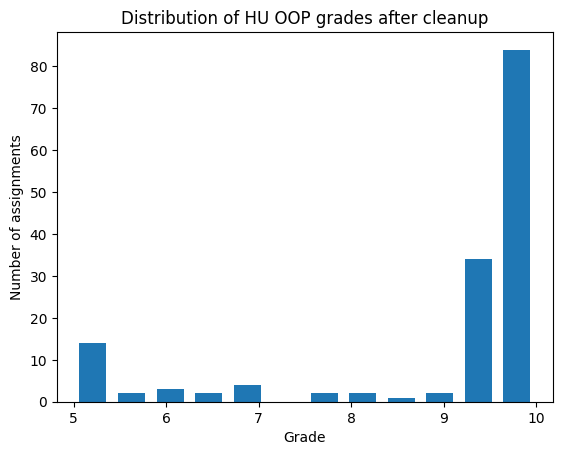

In [6]:
ax = abt_final['grade'].hist(bins=12, rwidth = 0.7)
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HU OOP grades after cleanup')
plt.show()

## Distribution of failing grades before cleanup

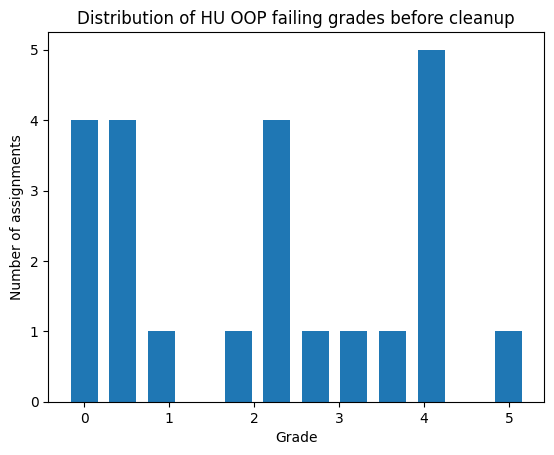

In [7]:
ax = abt[abt['grade'] < 5.5]['grade'].hist(
    bins = 12, 
    rwidth = 0.7, 
    align="left")
ax.grid(False)
ax.set_xlabel('Grade')
ax.set_ylabel('Number of assignments')
ax.set_title('Distribution of HU OOP failing grades before cleanup')
plt.show()

# Correlations

## Correlations for all grades

In [8]:
corr = abt_final.corr(method='spearman') # Spearman to correct for non-normal distribution. Effect is very small, however.
corr.style.background_gradient(cmap='coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.201769,0.330026,0.408505,0.219608,0.044442,0.186234,0.005598,-0.178917,0.365714,0.339117,0.296285,0.149076,0.342580,-0.197546,0.195601,-0.094861,-0.145995,0.312184,0.116584,0.211376,0.161787,0.296285,-0.010553,0.342580,0.161787
errors_count,-0.201769,1.000000,0.221244,0.155879,-0.066528,0.269308,0.028654,0.163919,0.955254,0.192405,0.113977,0.109688,0.261599,0.089077,0.873451,0.085293,0.037366,0.190602,0.018586,-0.074404,-0.069121,0.001189,0.109688,0.263533,0.089077,0.001189
errors_total,0.330026,0.221244,1.000000,0.873594,0.263560,0.451384,0.715894,0.203458,0.177870,0.846415,0.546451,0.737509,0.458735,0.417473,0.240487,0.782535,0.081760,0.502682,0.649328,0.074868,0.294657,0.151512,0.737509,0.585017,0.417473,0.151512
cluster_Best practices,0.408505,0.155879,0.873594,1.000000,0.294717,0.153234,0.479624,0.118249,0.111346,0.860478,0.630669,0.784345,0.348682,0.537402,0.183567,0.562141,0.079670,0.344389,0.496336,0.034896,0.314299,0.281855,0.784345,0.400653,0.537402,0.281855
cluster_Complexity,0.219608,-0.066528,0.263560,0.294717,1.000000,-0.003108,0.144365,0.102937,-0.141628,0.272399,0.139171,0.269459,0.140416,0.169753,0.051423,0.164032,0.169037,-0.031257,0.178686,0.150855,0.543489,0.561594,0.269459,0.068846,0.169753,0.561594
cluster_Incomplete code,0.044442,0.269308,0.451384,0.153234,-0.003108,1.000000,0.144808,0.040283,0.308250,0.306668,0.101887,0.298817,0.233225,0.001677,0.145458,0.456161,-0.052285,0.153751,0.468057,0.006266,-0.047433,-0.074341,0.298817,0.220648,0.001677,-0.074341
cluster_Reusability and extendibility,0.186234,0.028654,0.715894,0.479624,0.144365,0.144808,1.000000,0.251393,-0.033146,0.482693,0.270240,0.364960,0.408848,0.170048,0.122692,0.743427,0.092515,0.648621,0.491000,0.143802,0.246364,-0.008006,0.364960,0.707343,0.170048,-0.008006
cluster_Side effects,0.005598,0.163919,0.203458,0.118249,0.102937,0.040283,0.251393,1.000000,0.145403,0.185673,0.123615,0.191845,0.117299,0.163285,0.174979,0.192308,0.157408,0.129709,0.111100,0.013210,0.083017,0.035414,0.191845,0.177716,0.163285,0.035414
pmd_count,-0.178917,0.955254,0.177870,0.111346,-0.141628,0.308250,-0.033146,0.145403,1.000000,0.192334,0.155381,0.084304,0.247878,0.119835,0.709958,0.039445,0.009040,0.118436,-0.006959,-0.146207,-0.194882,-0.065444,0.084304,0.191164,0.119835,-0.065444
pmd_total,0.365714,0.192405,0.846415,0.860478,0.272399,0.306668,0.482693,0.185673,0.192334,1.000000,0.547087,0.872382,0.618536,0.447912,0.166824,0.412152,0.080464,0.362368,0.303246,-0.084909,0.302601,0.177238,0.872382,0.531368,0.447912,0.177238


In [9]:
pearson_vals = []
pd.reset_option('display.float_format')
# pd.options.display.float_format = '{:,.4f}'.format
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final['grade'], abt_final[cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Metric' : cat,
        'Average value': float(round(abt_final[cat].mean() * 100)) / 100,
        'SD' : float(round(abt_final[cat].std() * 100)) / 100,
        'Correlation coefficient' : float(round(result.statistic * 100)) / 100,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 low' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals).to_excel('data/hu_oop_pearson_vals.xlsx')
pd.DataFrame(pearson_vals)

,Metric,Average value,SD,Correlation coefficient,P-value,P-value disp,Confidence interval .99 low,Confidence interval .99 high
0,errors_count,26.08,4.44,-0.31,0.000121,0.00012,-0.486581,-0.106267
1,errors_total,537.19,60.10,0.29,0.000283,0.00028,0.088497,0.472770
2,cluster_Best practices,272.23,31.38,0.36,0.000005,0.00000,0.165079,0.530977
3,cluster_Complexity,0.98,1.39,0.25,0.001897,0.00189,0.044654,0.437864
4,cluster_Incomplete code,76.22,14.78,0.05,0.579071,0.57907,-0.165237,0.252551
5,cluster_Reusability and extendibility,186.72,30.31,0.16,0.045180,0.04518,-0.047121,0.360748
6,cluster_Side effects,1.04,1.58,0.14,0.078360,0.07835,-0.067157,0.343136
7,pmd_count,17.03,2.99,-0.29,0.000305,0.00030,-0.471492,-0.086866
8,pmd_total,340.82,31.75,0.36,0.000005,0.00000,0.165996,0.531654
9,pmd_cat_Best practices,52.12,10.90,0.17,0.041004,0.04100,-0.043768,0.363667


## Correlations for passing grades only

In [10]:
corr = abt_final[abt_final['grade'] >= 5.5].corr()
corr.style.background_gradient(cmap='coolwarm')

,grade,errors_count,errors_total,cluster_Best practices,cluster_Complexity,cluster_Incomplete code,cluster_Reusability and extendibility,cluster_Side effects,pmd_count,pmd_total,pmd_cat_Best practices,pmd_cat_Code style,pmd_cat_Design,pmd_cat_ErrorProne,checkstyle_count,checkstyle_total,checkstyle_cat_Block Checks,checkstyle_cat_Class Design,checkstyle_cat_Coding,checkstyle_cat_Imports,checkstyle_cat_Metrics,checkstyle_cat_SizeViolations,cat_Code style,cat_Design,cat_ErrorProne,cat_SizeViolations
grade,1.000000,-0.103155,0.228320,0.213434,0.134225,0.126191,0.159544,0.044112,-0.095323,0.213653,0.158591,0.164412,0.123827,0.175004,-0.091810,0.169455,-0.173667,-0.010948,0.253446,0.098443,0.156321,0.073969,0.164412,0.041043,0.175004,0.073969
errors_count,-0.103155,1.000000,0.395781,0.308485,0.101519,0.344648,0.275182,0.178679,0.944630,0.373208,0.160495,0.306747,0.329814,0.180820,0.857809,0.291528,0.048076,0.314014,0.197938,0.030553,0.105398,0.031339,0.306747,0.376066,0.180820,0.031339
errors_total,0.228320,0.395781,1.000000,0.848970,0.148310,0.478986,0.848078,0.091466,0.279602,0.771772,0.506811,0.668943,0.451136,0.284149,0.487152,0.869544,0.055900,0.735142,0.743274,0.110643,0.241155,0.101612,0.668943,0.751957,0.284149,0.101612
cluster_Best practices,0.213434,0.308485,0.848970,1.000000,0.146924,0.224585,0.534984,0.014338,0.235907,0.878567,0.672648,0.768468,0.369727,0.454295,0.351549,0.564753,0.048261,0.447946,0.507399,-0.014517,0.200113,0.206945,0.768468,0.496142,0.454295,0.206945
cluster_Complexity,0.134225,0.101519,0.148310,0.146924,1.000000,-0.044094,0.118981,-0.027427,-0.004220,0.149429,0.046812,0.111657,0.163800,0.108461,0.243901,0.101806,0.082224,0.085962,0.060319,0.011663,0.722863,0.521514,0.111657,0.132368,0.108461,0.521514
cluster_Incomplete code,0.126191,0.344648,0.478986,0.224585,-0.044094,1.000000,0.210374,-0.063616,0.374170,0.406730,0.132966,0.415853,0.289640,0.007453,0.219511,0.387717,-0.039147,0.218417,0.419992,0.045518,-0.029637,-0.086514,0.415853,0.285682,0.007453,-0.086514
cluster_Reusability and extendibility,0.159544,0.275182,0.848078,0.534984,0.118981,0.210374,1.000000,0.143788,0.112824,0.413854,0.236878,0.324733,0.358964,0.086165,0.466495,0.924350,0.072783,0.867749,0.720741,0.205875,0.253222,0.012408,0.324733,0.818145,0.086165,0.012408
cluster_Side effects,0.044112,0.178679,0.091466,0.014338,-0.027427,-0.063616,0.143788,1.000000,0.148041,0.011929,0.180948,-0.066240,-0.048077,0.091247,0.185767,0.125092,0.072610,0.077906,0.129918,0.018621,-0.037106,-0.038631,-0.066240,0.041317,0.091247,-0.038631
pmd_count,-0.095323,0.944630,0.279602,0.235907,-0.004220,0.374170,0.112824,0.148041,1.000000,0.364759,0.192160,0.280973,0.314777,0.205650,0.641661,0.127433,0.012962,0.159937,0.076331,-0.035719,-0.051649,-0.051312,0.280973,0.250285,0.205650,-0.051312
pmd_total,0.213653,0.373208,0.771772,0.878567,0.149429,0.406730,0.413854,0.011929,0.364759,1.000000,0.585635,0.882057,0.630699,0.365639,0.301009,0.357047,0.057478,0.378892,0.255056,-0.129976,0.189267,0.101465,0.882057,0.546903,0.365639,0.101465


In [11]:
pearson_vals = []
for cat in abt_final.columns.to_numpy():
    if cat == 'grade':
        continue
    result = pearsonr(abt_final[abt_final['grade'] >= 5.5]['grade'], abt_final[abt_final['grade'] >= 5.5][cat])
    confidence_interval = result.confidence_interval(confidence_level = 0.99)
    pearson_vals.append({
        'Metric' : cat,
        'Coefficient' : result.statistic,
        'P-value' : result.pvalue,
        'P-value disp' : float(int(result.pvalue * 100000)) / 100000,
        'Confidence interval .99 confidence_interval[0]' : confidence_interval[0],
        'Confidence interval .99 high' : confidence_interval[1],
    })
pd.DataFrame(pearson_vals)

,Metric,Coefficient,P-value,P-value disp,Confidence interval .99 confidence_interval[0],Confidence interval .99 high
0,errors_count,-0.103155,0.233814,0.23381,-0.316471,0.120091
1,errors_total,0.228320,0.007735,0.00773,0.008219,0.427320
2,cluster_Best practices,0.213434,0.012936,0.01293,-0.007431,0.414443
3,cluster_Complexity,0.134225,0.120642,0.12064,-0.088921,0.344542
4,cluster_Incomplete code,0.126191,0.144727,0.14472,-0.097023,0.337319
5,cluster_Reusability and extendibility,0.159544,0.064551,0.06455,-0.063194,0.367142
6,cluster_Side effects,0.044112,0.611439,0.61143,-0.178135,0.262078
7,pmd_count,-0.095323,0.271438,0.27143,-0.309335,0.127880
8,pmd_total,0.213653,0.012841,0.01284,-0.007201,0.414633
9,pmd_cat_Best practices,0.158591,0.066185,0.06618,-0.064168,0.366296


# Distribution of errors

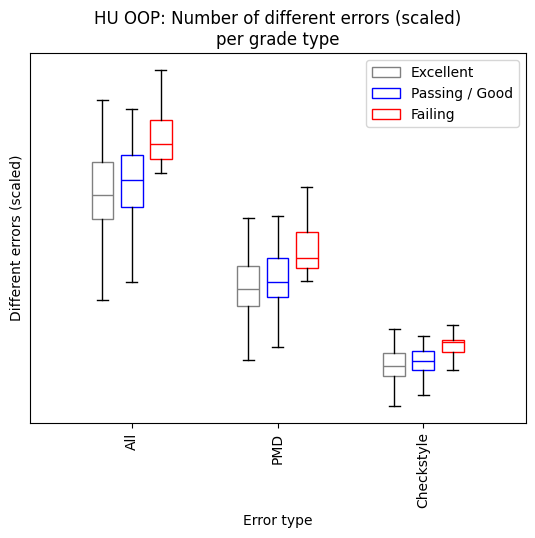

In [12]:
plot_boxes_grade_cats(abt_final, ['errors_count', 'pmd_count', 'checkstyle_count'],
           ['All', 'PMD', 'Checkstyle'],
           "HU OOP: Number of different errors (scaled)\nper grade type",
           'Error type',
           'Different errors (scaled)',
           hide_y = True
           )

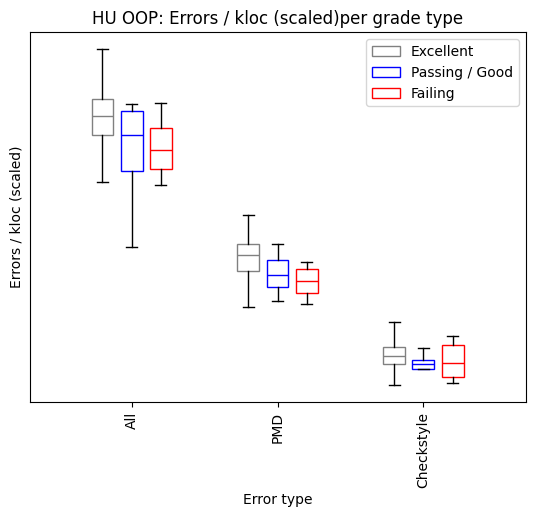

In [13]:
plot_boxes_grade_cats(abt_final, ['errors_total', 'pmd_total', 'checkstyle_total'],
           ['All', 'PMD', 'Checkstyle'],
           "HU OOP: Errors / kloc (scaled)per grade type",
           'Error type',
           'Errors / kloc (scaled)',
           hide_y = True
           )

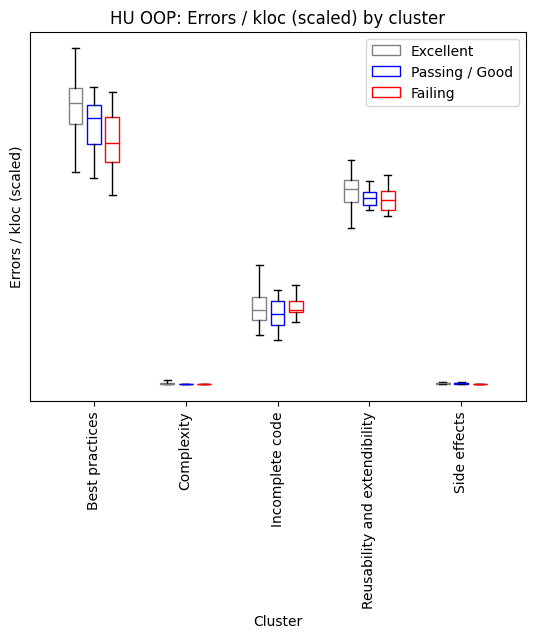

In [14]:
cluster_columns = [x for x in abt_final.columns if x.startswith("cluster_")]
labels = [x.replace('cluster_', '') for x in cluster_columns]


plot_boxes_grade_cats(abt_final,
           cluster_columns,
           labels,
           'HU OOP: Errors / kloc (scaled) by cluster',
           'Cluster',
           'Errors / kloc (scaled)',
           hide_y = True
           )

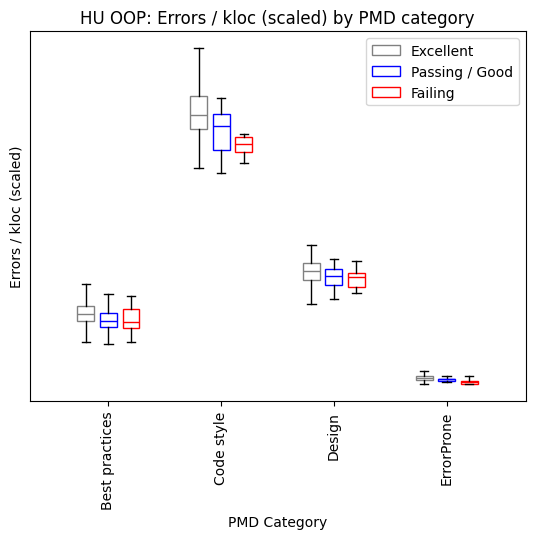

In [15]:
# Individual PMD categories
categories = [x for x in abt_final.columns if x.startswith('pmd_cat_')]
labels = [x.replace('pmd_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'HU OOP: Errors / kloc (scaled) by PMD category',
           'PMD Category',
           'Errors / kloc (scaled)',
           hide_y = True)

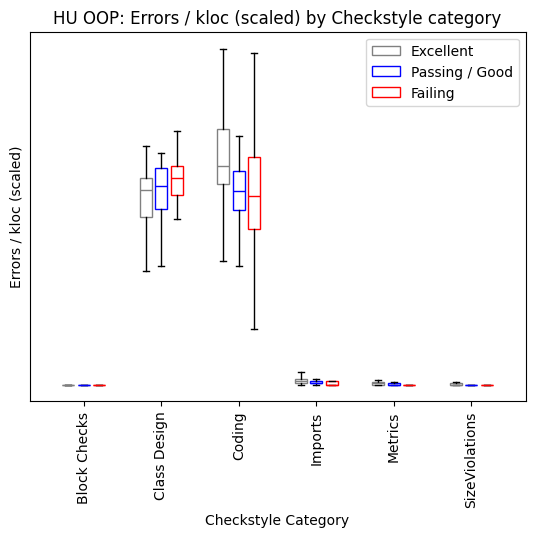

In [16]:
# Individual Checkstyle categories
categories = [x for x in abt_final.columns if x.startswith('checkstyle_cat_')]
labels = [x.replace('checkstyle_cat_', '') for x in categories]

plot_boxes_grade_cats(abt_final,
    categories,
           labels,
           'HU OOP: Errors / kloc (scaled) by Checkstyle category',
           'Checkstyle Category',
           'Errors / kloc (scaled)',
           hide_y = True)

/var/folders/zc/pfyjhy252g1fmlpp0765mxtm0000gn/T/ipykernel_62254/3240813663.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']


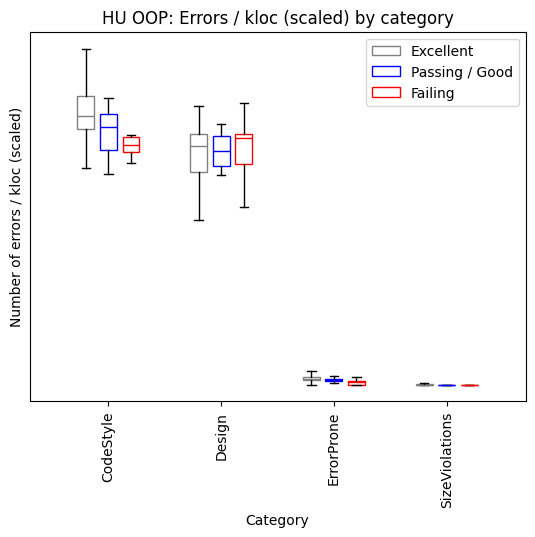

In [17]:
# Categories teachers were questioned on
# Individual PMD categories
abt_cats = abt_final[['grade', 
                      'checkstyle_cat_Class Design',
                      'checkstyle_cat_SizeViolations',
                      'pmd_cat_Design',
                      'pmd_cat_Code style',
                      'pmd_cat_ErrorProne',
                      ]]
abt_cats.loc[:, ('Design')] = abt_cats['checkstyle_cat_Class Design'] + abt_cats['pmd_cat_Design']
abt_cats = abt_cats.rename({
    'checkstyle_cat_SizeViolations': 'SizeViolations',
    'pmd_cat_Code style' : 'CodeStyle',
    'pmd_cat_ErrorProne' : 'ErrorProne'
}, axis = 1).drop(['checkstyle_cat_Class Design', 'pmd_cat_Design'], axis = 1)

categories = [x for x in abt_cats.columns if x != 'grade']
categories.sort()



plot_boxes_grade_cats(abt_cats,
    categories,
           categories,
           'HU OOP: Errors / kloc (scaled) by category',
           'Category',
           'Number of errors / kloc (scaled)',
           hide_y = True)